## Setup

(1) Install IPyKernel

```console
pip install ipykernel
```

(2) Install FlexMeasures IPython Kernel

```console
ipython -m ipykernel install --user --name=fm
```

In [1]:
from flexmeasures.app import create
from flexmeasures.data.models.time_series import Sensor

from datetime import timedelta

from flexmeasures.data.utils import save_to_db

from sqlalchemy import select, update
import time

import timely_beliefs as tb
import pandas as pd
import numpy as np

from flexmeasures.data.services.utils import get_or_create_model
from flexmeasures import Asset, Sensor, AssetType, Account, Source
from flexmeasures.data.models.time_series import TimedBelief

app = create()

[FLEXMEASURES][2024-07-09 09:58:49,437] INFO: Loading config from /home/victor/.flexmeasures.cfg ...
You might consider setting MAIL_PASSWORD.
[FLEXMEASURES][2024-07-09 09:58:49,438] INFO: [FLEXMEASURES] No SENTRY_DSN setting found, so initialising Sentry cannot happen ...
[FLEXMEASURES][2024-07-09 09:58:49,891] WARNING: `app.reporters` is deprecated. Use `app.data_generators["reporter"]` instead.
[FLEXMEASURES][2024-07-09 09:58:49,983] INFO: Importing plugin flexmeasures_simulate ...
[FLEXMEASURES][2024-07-09 09:58:50,236] INFO: Importing plugin flexmeasures-entsoe ...
[FLEXMEASURES][2024-07-09 09:58:50,238] INFO: Missing config setting 'ENTSOE_COUNTRY_TIMEZONE' (IANA timezone name used to localize ENTSO-E sensors.). 'Europe/Amsterdam' will be used as a default.
[FLEXMEASURES][2024-07-09 09:58:50,238] INFO: Importing plugin flexmeasures_smartbuildings ...
[FLEXMEASURES][2024-07-09 09:58:50,300] INFO: Importing plugin flexmeasures_seita ...
[FLEXMEASURES][2024-07-09 09:58:50,303] INFO:

In [2]:
ctx = app.app_context()

In [3]:
ctx.__enter__()

In [4]:
from flexmeasures.data.models.planning.linear_optimization import device_scheduler
import pandas as pd

COLUMNS = [
    "equals",
    "max",
    "min",
    "efficiency",
    "derivative equals",
    "derivative max",
    "derivative min",
    "derivative down efficiency",
    "derivative up efficiency",
    "stock delta",
]

In [5]:
import numpy as np


resolution = timedelta(minutes=15)
dt = pd.date_range("2024-01-01", "2024-01-03", freq="15min", inclusive="left")

commitment_upwards_deviation_price = pd.Series([100]*len(dt), index=dt) # Consumption Price
commitment_downwards_deviation_price = pd.Series([70]*len(dt), index=dt) # Production

#commitment_downwards_deviation_price[:10] = 10
#commitment_upwards_deviation_price[:10] = 10

commitment_upwards_deviation_price += -np.arange(len(dt))*0.2
commitment_downwards_deviation_price += -np.arange(len(dt))*0.2

commitment_quantities = pd.Series([0]*len(dt), index=dt)

ems_constraints = pd.DataFrame(columns=COLUMNS, index=dt)
ems_constraints["derivative max"] = 30
ems_constraints["derivative min"] = -30

n_devices = 1

soc_at_start = 5

soc_min = 10
soc_max = 90

storage_efficiency = 1
roundtrip_efficiency = .9

# Base device constraints
dc_main =  pd.DataFrame(columns=COLUMNS, index=dt)
dc_main["min"] = (soc_min - soc_at_start) * timedelta(hours=1) / resolution
dc_main["max"] =  (soc_max - soc_at_start) * timedelta(hours=1) / resolution

dc_main["efficiency"] = storage_efficiency

dc_main["derivative max"] = 5
dc_main["derivative min"] = -5

dc_main["derivative down efficiency"] = roundtrip_efficiency ** .5
dc_main["derivative up efficiency"] = roundtrip_efficiency ** .5

d = 0

#dc_main["max"][-20] = (110 - soc_at_start) * timedelta(hours=1) / resolution
dc_main["min"][30+d:40+d] = (60 - soc_at_start) * timedelta(hours=1) / resolution
dc_main["max"][50+d:60+d] = (40 - soc_at_start) * timedelta(hours=1) / resolution
dc_main["min"][50+d:60] = (40 - soc_at_start) * timedelta(hours=1) / resolution
dc_main["min"][70+d:80+d] = (60 - soc_at_start) * timedelta(hours=1) / resolution
dc_main["max"][90+d:100+d] = (20 - soc_at_start) * timedelta(hours=1) / resolution

# dc_main["equals"][-20] = (110 - soc_at_start) * timedelta(hours=1) / resolution

device_constraints = []

#device_constraints.append(dc_main)

for i in range(n_devices):
    dc = dc_main.copy()
    #dc["derivative down efficiency"] += 1
    device_constraints.append(dc)

# # Add some inflexible
# dc =  pd.DataFrame(columns=COLUMNS, index=dt)
# dc["derivative equals"] = 1
# dc["derivative equals"][10:20] = -2
# dc["derivative equals"][20:40] = -1.5
# dc["derivative equals"][40:50] = -2
# dc["derivative equals"][70:80] = -2
# dc *= -1
# device_constraints.append(dc)


/tmp/ipykernel_96523/92485254.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dc_main["min"][30+d:40+d] = (60 - soc_at_start) * timedelta(hours=1) / resolution
/tmp/ipykernel_96523/92485254.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dc_main["max"][50+d:60+d] = (40 - soc_at_start) * timedelta(hours=1) / resolution
/tmp/ipykernel_96523/92485254.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dc_main["min"][50+d:60] = 

In [15]:
planned_power_per_device, planned_costs, results, model = device_scheduler(
    device_constraints,
    ems_constraints,
    [commitment_quantities],
    [commitment_downwards_deviation_price],
    [commitment_upwards_deviation_price],
    initial_stock = soc_at_start * (timedelta(hours=1) / resolution),
    ems_flow_relaxed = False,
    device_stock_relaxed = True,
    ems_flow_relaxation_cost = 20000,
    stock_relaxation_cost = 20000,
    device_downwards_price=[commitment_downwards_deviation_price, commitment_downwards_deviation_price, commitment_downwards_deviation_price],
    device_upwards_price=[commitment_downwards_deviation_price, commitment_downwards_deviation_price, commitment_downwards_deviation_price],
    device_future_reward=[1]
)

[FLEXMEASURES][2024-07-09 10:01:03,423] WARNING: DEPRECATED: Using __getitem__ to return a set value from its (ordered)
position is deprecated.  Please use at()  (deprecated in 6.1, will be
removed in (or after) 7.0)
(called from /home/victor/Work/Seita/flexmeasures/flexmeasures/data/models/planning/linear_optimization.py:467)
[FLEXMEASURES][2024-07-09 10:01:03,620] INFO: Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d-dirty]
[FLEXMEASURES][2024-07-09 10:01:03,665] INFO: Copyright (c) 2023 HiGHS under MIT licence terms


In [16]:
from flexmeasures.utils.calculations import integrate_time_series
soc_schedule = integrate_time_series(
        planned_power_per_device[0],
        soc_at_start,
        up_efficiency=roundtrip_efficiency**0.5,
        down_efficiency=roundtrip_efficiency**0.5,
        storage_efficiency=storage_efficiency,
        decimal_precision=6,
    )

In [19]:
def get_soc(d):
    d = d  * 2
    import numpy as np
    

    resolution = timedelta(minutes=15)
    dt = pd.date_range("2024-01-01", "2024-01-03", freq="15min", inclusive="left")
    
    commitment_upwards_deviation_price = pd.Series([100]*len(dt), index=dt) # Consumption Price
    commitment_downwards_deviation_price = pd.Series([70]*len(dt), index=dt) # Production
    
    #commitment_downwards_deviation_price[:10] = 10
    #commitment_upwards_deviation_price[:10] = 10
    
    commitment_upwards_deviation_price += -np.arange(len(dt))*0.2
    commitment_downwards_deviation_price += -np.arange(len(dt))*0.2
    
    commitment_quantities = pd.Series([0]*len(dt), index=dt)
    
    ems_constraints = pd.DataFrame(columns=COLUMNS, index=dt)
    ems_constraints["derivative max"] = 30
    ems_constraints["derivative min"] = -30
    
    n_devices = 1
    
    soc_at_start = 5
    
    soc_min = 10
    soc_max = 90
    
    storage_efficiency = 1
    roundtrip_efficiency = .9
    
    # Base device constraints
    dc_main =  pd.DataFrame(columns=COLUMNS, index=dt)
    dc_main["min"] = (soc_min - soc_at_start) * timedelta(hours=1) / resolution
    dc_main["max"] =  (soc_max - soc_at_start) * timedelta(hours=1) / resolution
    
    dc_main["efficiency"] = storage_efficiency
    
    dc_main["derivative max"] = 5
    dc_main["derivative min"] = -5
    
    dc_main["derivative down efficiency"] = roundtrip_efficiency ** .5
    dc_main["derivative up efficiency"] = roundtrip_efficiency ** .5
    
    
    #dc_main["max"][-20] = (110 - soc_at_start) * timedelta(hours=1) / resolution
    dc_main["min"][30+d:40+d] = (60 - soc_at_start) * timedelta(hours=1) / resolution
    dc_main["max"][50+d:60+d] = (40 - soc_at_start) * timedelta(hours=1) / resolution
    dc_main["min"][50+d:60+d] = (40 - soc_at_start) * timedelta(hours=1) / resolution
    dc_main["min"][70+d:80+d] = (60 - soc_at_start) * timedelta(hours=1) / resolution
    dc_main["max"][90+d:100+d] = (20 - soc_at_start) * timedelta(hours=1) / resolution
    
    # dc_main["equals"][-20] = (110 - soc_at_start) * timedelta(hours=1) / resolution
    
    device_constraints = []
    
    #device_constraints.append(dc_main)
    
    for i in range(n_devices):
        dc = dc_main.copy()
        #dc["derivative down efficiency"] += 1
        device_constraints.append(dc)

    planned_power_per_device, planned_costs, results, model = device_scheduler(
        device_constraints,
        ems_constraints,
        [commitment_quantities],
        [commitment_downwards_deviation_price],
        [commitment_upwards_deviation_price],
        initial_stock = soc_at_start * (timedelta(hours=1) / resolution),
        ems_flow_relaxed = False,
        device_stock_relaxed = True,
        ems_flow_relaxation_cost = 20000,
        stock_relaxation_cost = 20000,
        device_downwards_price=[commitment_downwards_deviation_price, commitment_downwards_deviation_price, commitment_downwards_deviation_price],
        device_upwards_price=[commitment_downwards_deviation_price, commitment_downwards_deviation_price, commitment_downwards_deviation_price],
        device_future_reward=[1]
    )

    from flexmeasures.utils.calculations import integrate_time_series
    soc_schedule = integrate_time_series(
        planned_power_per_device[0],
        soc_at_start,
        up_efficiency=roundtrip_efficiency**0.5,
        down_efficiency=roundtrip_efficiency**0.5,
        storage_efficiency=storage_efficiency,
        decimal_precision=6,
    )


    return dc_main, soc_schedule

    

[FLEXMEASURES][2024-07-09 10:13:08,122] INFO: Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d-dirty]
[FLEXMEASURES][2024-07-09 10:13:08,200] INFO: Copyright (c) 2023 HiGHS under MIT licence terms
[FLEXMEASURES][2024-07-09 10:13:08,611] INFO: Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d-dirty]
[FLEXMEASURES][2024-07-09 10:13:08,716] INFO: Copyright (c) 2023 HiGHS under MIT licence terms


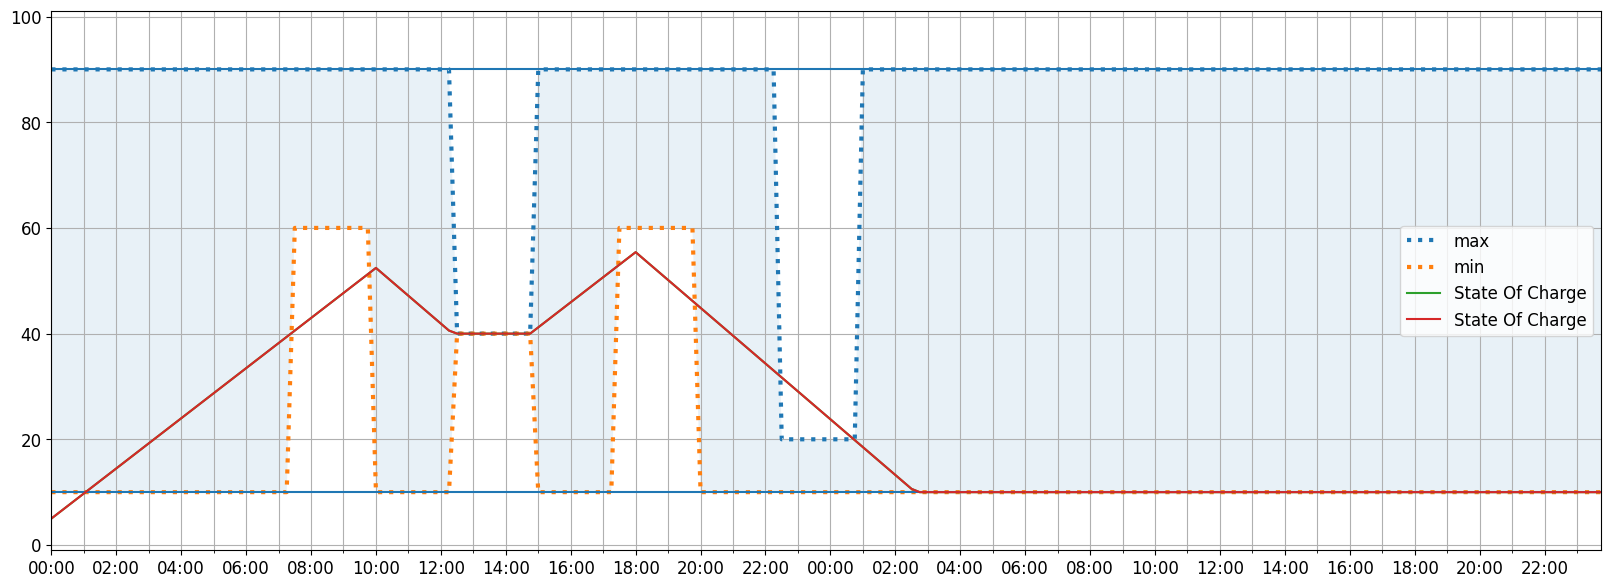

In [24]:
import matplotlib.pyplot as plt
import matplotlib.dates as md
import matplotlib.animation as animation
import warnings
import pandas as pd
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=(SettingWithCopyWarning))

fig, ax = plt.subplots(figsize=(20,7))

def update_plot(d):
    ax.cla()
    dc_main, soc_schedule = get_soc(2*d)

    ax.plot(dc_main[["max", "min"]] * resolution / timedelta(hours=1) + soc_at_start, label=["max", "min"], ls="dotted", lw=3)

    ax.fill_between(dc_main.index, dc_main["min"] * resolution/timedelta(hours=1) + soc_at_start,
                     dc_main["max"] * resolution / timedelta(hours=1) + soc_at_start, alpha= 0.1)
    ax.plot(soc_schedule, label="State Of Charge")
    ax.grid()
    plt.ylim(-1, 101)
    ax.axhline(90)
    ax.axhline(10)
    ax.plot(soc_schedule, label="State Of Charge")
    ax.xaxis.set_major_locator(md.HourLocator(interval=2))
    ax.xaxis.set_minor_locator(md.HourLocator(interval=1))
    ax.xaxis.grid(True, which="minor")
    ax.xaxis.set_major_formatter(md.DateFormatter("%H:%M"))
    ax.set(xlim=[dc_main.index[0], dc_main.index[-1]], ylim=[-1,101])    
    plt.rc("font", **{"size" : 12})
    plt.tick_params(axis="x", which="minor")
    ax.legend()
update_plot(0)


ani = animation.FuncAnimation(fig=fig, func=update_plot, frames=20, interval=1000)
#ani.save("prueba.mp4")

In [27]:
from IPython.display import HTML
a = ani.to_html5_video()
HTML(a)


[FLEXMEASURES][2024-07-09 10:02:20,063] INFO: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
[FLEXMEASURES][2024-07-09 10:02:20,064] INFO: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 2000x700 -pix_fmt rgba -framerate 1.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y prueba.mp4
[FLEXMEASURES][2024-07-09 10:02:20,639] INFO: Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d-dirty]
[FLEXMEASURES][2024-07-09 10:02:20,702] INFO: Copyright (c) 2023 HiGHS under MIT licence terms
[FLEXMEASURES][2024-07-09 10:02:21,346] INFO: Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d-dirty]
[FLEXMEASURES][2024-07-09 10:02:21,416] INFO: Copyright (c) 2023 HiGHS under MIT licence terms
[FLEXMEASURES][2024-07-09 10:02:22,044] INFO: Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d-dirty]
[FLEXMEASURES][2024-07-09 10:02:22,149] INFO: Copyright (c) 2023 HiGHS under MIT licence terms
[FLEXMEASURES][2024-07-09 10:02:22,736] I

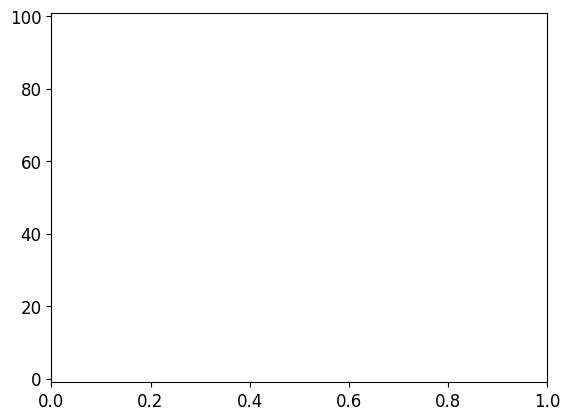

In [22]:
ani.save("prueba.mp4")

In [ ]:
results.solver.termination_condition
pd.Series(model.device_stock_slack_lower.extract_values()).plot()
plt.show()
pd.Series(model.device_stock_slack_upper.extract_values()).plot()
results.solver.termination_condition

In [ ]:
planned_costs

In [ ]:
import matplotlib.pyplot as plt
for i, power in enumerate(planned_power_per_device):
    plt.plot(power, label=i)
plt.legend()
plt.grid()
plt.tight_layout()

In [ ]:
min(sum(planned_power_per_device)), max(sum(planned_power_per_device))

In [ ]:
plt.plot(sum(planned_power_per_device))

In [ ]:
plt.plot(commitment_upwards_deviation_price, label="up")
plt.plot(commitment_downwards_deviation_price, label="down")

plt.legend()